# DQN avec réseau convolutionnel
(c) Fabrice Mulotti + nombreuses sources sur internet

In [ ]:
%pip install pillow

In [2]:
import tensorflow as tf
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
import timeit
import ale_py
from skimage.transform import resize
from skimage.color import rgb2gray
import os
import matplotlib.pyplot as plt
import time

## Exemple si vous utilisez prometheus / grafana pour le suivi
from prometheus_client import start_http_server, Gauge<br>
collectReturn = Gauge(os.uname()[1] + "_dqn_atari_return","DQn Atari")<br>

start_http_server(9222)

In [3]:
# Check version
print(tf.__version__)
print("Version numpy : ",np.__version__)
print(f"GPU?{tf.config.list_physical_devices('GPU')}")

2.18.0
Version numpy :  2.0.2
GPU?[]


2024-10-28 20:58:34.236194: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Environnement --------------------------------------
ENV="ALE/Pong-v5"
env=gym.make(ENV,render_mode= "rgb_array", obs_type = "grayscale")
action_size=env.action_space.n

# ## Dimensions cible pour diminuer le temps de traitement
state_size = (88, 80, 1)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


In [5]:
# Ecrivez une fonction qui prend en entrée l'image du jeux - sous format greyscale
# La fonction doit réduire l'image à 88,80 puis normaliser les pixels (exemple entre 0 et 1 moyenne 0.5)
# La fonction doit ensuite retourner un numpy format 88,80,1

# Exemple de fonction utilise from skimage.transform import resize
# Mais il en existe d'autre

In [6]:
# Réduction de la taille des images
def getState(state):
    state=resize(state,(88,80),anti_aliasing=False)
    # state = state/256 # à utiliser suivant l'outil de réduction d'image utilisé
    return np.expand_dims(state,axis=2)

In [7]:
s=env.reset()[0]

In [8]:
s.shape

(210, 160)

In [9]:
s.mean()

np.float64(103.39904761904762)

In [10]:
print(f"min {s.min()}, max {s.max()}")

min 0, max 179


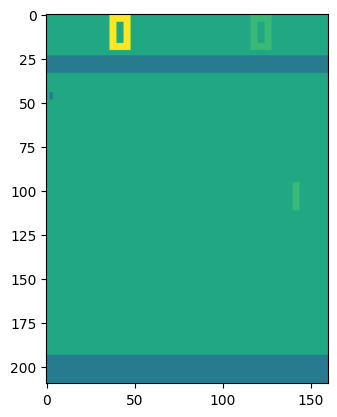

In [11]:
plt.imshow(s)

In [12]:
s_reduce=getState(s)
print(s_reduce.shape)

(88, 80, 1)


In [3]:
# Vérifions que tout est beau
assert s_reduce.shape == (88,80,1)

NameError: name 's' is not defined

In [ ]:
s_reduce.mean()

In [ ]:
print(f"min {s_reduce.min()}, max {s_reduce.max()}")

In [ ]:
plt.imshow(getState(s))

# Classe DQN

In [ ]:
# ## Notre classe DQN
class DQN:
    def __init__(self, state_size, action_size, gamma = 0.99, update_rate=2000,lr=2.5e-4):
        
        #dimension état
        self.state_size = state_size
        
        #nombre action
        self.action_size = action_size
        
        # déclaration + taille replay buffer
        self.replay_buffer = deque(maxlen=100000)
        
        # dévaluation
        self.gamma = gamma
                
        # fréquence de copie des poids main-> target
        self.update_rate = update_rate

        # learning rate
        self.lr=lr
        
        # réseau main
        self.main_network = self.build_network()
        
        # réseau target
        self.target_network = self.build_network()
        
        #initialisation poids identiques
        self.target_network.set_weights(self.main_network.get_weights())
        

    # construction réseau 
    def build_network(self):
        model = Sequential()
        model.add(Input(shape=self.state_size))

        # ajoutez 2 ou 3 couches cachées de  type convolutionnel
        #.      L'activation sera de type relu
        # Mettre à "plat" ensuite les couches
        # ajouter une couche dense 512 neurones/relu
        # ajouter une couche de sortie avec un neurone par action possible, type linear

        
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr),jit_compile=True)

        return model


    def transformState(self,state):
        return np.expand_dims(state,axis=0)
    
    # enregistrement SARS dans replay buffer
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    # choix action epsilon greedy
    def epsilon_greedy(self, state,epsilon):
        
        if random.uniform(0,1) < epsilon:
            return np.random.randint(self.action_size)
        
        # print(state.shape,self.transformState(state).shape)
        Q_values = self.main_network.predict_on_batch(self.transformState(state)) 
        
        return np.argmax(Q_values[0])

    @tf.function
    def _train(self,states,targets):
        self.main_network.fit(states, targets, epochs=1, verbose=0)
                         
    def train_model(self,batch_size):
 
        # sélection d'un échantillon
        minibatch = random.sample(self.replay_buffer,batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*minibatch))

        states=states.squeeze()
        next_states=next_states.squeeze()
        
        # On récupere les Q values des états rencontrés
        Q_values = self.main_network.predict(states,verbose = 0)
        
        Updates = rewards + self.gamma * np.amax(self.target_network.predict(next_states,verbose=0),axis=1) * (1-dones)
        
        Q_values[ np.arange(len(Updates)),actions] = Updates
        
        self._train(states, Q_values)       

    # copie des poids main -> target
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())

# Entrainement

In [ ]:
# ## Training the network
num_episodes = 20000
num_timesteps = 5000 # max pour un  épisode
batch_size = 16 # nombre d enregistrement du replay buffer utilisé pour entrainer le modèle

# Si problème à ce stade, regardez si vous avez des processus qui consomme votre GPU (nvidia-smi)
dqn = DQN((88,80,1), action_size)

In [ ]:
weightsFile = "dqn_atari_poseidon.weights.h5"

# Decommentez si vous repartez d'un entrainement
#print("Load weights")
#dqn.main_network.load_weights(weightsFile)
#dqn.target_network.load_weights(weightsFile)

# ## C'est parti 
done = False
time_step = 0

# decay epsilon pour egreedy
epsilon_max = 1.0
epsilon_min=0.10
epsilon_decay=1000
epsilon = epsilon_max

returnHistory=[]
meanReturnShift=-1
startTime=time.time()
for i in range(num_episodes):
    
    Return = 0
    
    # on récupère notre premier état S
    # initialisez l'environnement, récupérez et transformez l'état
    # 2 lignes

    for t in range(num_timesteps):        
        
        time_step += 1
        
        # suivant notre fréquence copie des poids main-> target
        if time_step % dqn.update_rate == 0:
            dqn.update_target_network()
        
        # sélection action et exécution
        # sélectionnez une action avec egreedy
        # Jouez l'action et récupérer le retour de l'environnement
        # Transformez l'état
        # 3 lignes
        
        # option parfois conseille pour les entrainements suivant le systeme de recompense
        # if done:
        #    reward += -100

        # enregistrement SARS dans replay buffer
        dqn.store_transition(state, action, reward, next_state, done)
        
        # transition
        state = next_state
        
        Return += reward
        
        if i% 100 == 0:
            # env.render()
            dqn.main_network.save_weights(weightsFile)

        # entrainement
        if len(dqn.replay_buffer) > batch_size:
            dqn.train_model(batch_size)
            
        if done:
            r=max((epsilon_decay - i)/epsilon_decay,0)
            epsilon=(epsilon_max-epsilon_min)*r + epsilon_min
            break
            

    # stock le Gain
    returnHistory.append(Return)
    
    # collecte avec prometheus grafana
    # collectReturn.set(Return) 
    
    # calcul la moyenne glissante des récompenses
    if len(returnHistory)>100:
        meanReturnShift=np.round(sum(returnHistory[-100:])/100,0)
    
    print(f"Episode: {i}, Return={Return},in {t} moves,{time_step} total moves. \
    mean return={meanReturnShift}, \
    epsilon {np.round(epsilon,2)}. deque usage {np.round(len(dqn.replay_buffer)/1000,2)}% \
    , time/episode {np.round((time.time()-startTime)/(i+1))} sec")